# Difference in Differences

In this tutorial, we are going to see how to estimate the causal effect of a treatment on an outcome when treatment assignment is not random, but we observe both treated and untreated units before and after treatment. Under certain structural assumptions, especially parallel outcome trends in the absence of treatment, we can recover the average treatment effect.

**Requisites**

For this tutorial, I assume you are familiar with the following concepts:

- Rubin's potential outcome framework
- Ordinary least squares regression

**Academic Application**

As an academic application, we are going to replicate [Minimum Wages and Employment: A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania](http://sims.princeton.edu/yftp/emet04/ck/CardKruegerMinWage.pdf) (1994) by Card and Krueger. The authors study the effect of a minimum wage policy in New Jersey on emplyment, by using Pennsylvania as a control state.

**Business Case**

As a business case, we are going to study a firm that has run a TV ad campaign. The firm would like to understand the impact of the campaign on revenue and has randomized the campaign over municipalities.

## Setting

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ over $T$ time periods $t = 1 ,  ... , T$, we observed a tuple $(X_{it}, D_{it}, Y_{it})$ comprised of 

- a feature vector $X_{it} \in \mathbb R^{p}$
- a treatment assignment $D_i \in \lbrace 0, 1 \rbrace$
- a response $Y_{it} \in \mathbb R$

We assume that treatment occurs between time $t=0$ and time $t=1$.

**Assumption 1: parallel trends**

In the absence of treatment, the outcome $Y_{it}$ **evolve in parallel** across units, i.e. and their $\gamma_{t}$ are the same.

$$
Y_{it}^{(0)} - Y_{j,t}^{(0)} = \alpha \quad \forall \ t
$$

## Diff-in-diffs

In this setting, we cannot estimate any causal parameter with any other **further assumption**. What is the minimal number of assumptions that we could make in order to estimate a causal parameter?

If we were to assume that treatment was randomly assigned, we could retrieve the average treatment effect as a difference in means. 

$$
\mathbb E[\tau_t] = \mathbb E \big[ Y_{it} \ \big| \ D_i = 1 \big] - \mathbb E \big[ Y_{it} \big| \ D_i = 0 \big] 
$$

However, it would be a very strong assumption, and it would ignore some information that we possess: the time dimension (pre-post).

If we were to assume instead that no other shocks affected the treated units between period $t=0$ and $t=1$, we could retrieve the average treatment effect on the treated as a pre-post difference.

$$
\mathbb E[\tau | D_i=1] = \mathbb E \big[ Y_{i1} \ \big| \ D_i = 1 \big] - \mathbb E \big[ Y_{i0} \ \big| \ D_i = 1 \big] 
$$

However, it also this would be a very strong assumption, and it would ignore the fact that we have control units.

Can we make less stringent assumption and still recover a causal parameter using both the availability of a (non-random) control group and the time dimension?

### DiD Model

The model that is commonly assumed in diff-ind-diff settings, is the following

$$
Y_{it} (D_{it}) = \alpha_{i} + \gamma_{t} + \tau_{i} D_{it}
$$

First, let's summarize the potential outcome values $Y^{(d)}_{it}$ in the simple $2 \times 2$ setting.

|       | $t=0$                          | $t=1$                          |
|-------|--------------------------------|--------------------------------|
| $D=0$ | $\gamma_0 + \alpha_i$          | $\gamma_1 + \alpha_i$          |
| $D=1$ | $\gamma_0 + \alpha_i + \tau_i$ | $\gamma_1 + \alpha_i + \tau_i$ |

For a single unit, $i$, the pre-post outcome difference is given by

$$
Y_{i1} - Y_{i0} = (\gamma_1 - \gamma_0) + \tau_i (D_{i1} - D_{i0})
$$

If we take the difference of the expression above between treated and untreated units, we get 

$$
\mathbb E \Big[ Y_{i1} - Y_{i0} \ \Big| \ D_{i1} - D_{i0} = 1 \Big] - \mathbb E \Big[ Y_{i1} - Y_{i0} \ \Big| \ D_{i1} - D_{i0} = 0 \Big] = \mathbb E \Big[ \tau_i \ \Big| \ D_{i1} - D_{i0} = 1 \Big] = ATT
$$

which is the average treatment effect on the treated (ATT).

We can get this double difference with the folowing regressio model

$$
Y_{it} (D_{it}) = \alpha_{i} + \gamma_{t} + \beta D_{it} + \varepsilon_{it}
$$

where the OLS estimator $\hat \beta$ will be unbiased for the ATT.

### Multiple Time Periods

What if we didn't just have one pre-treatment period and one post-treatment period? Great! We can actually do more things.

1. We can partially test assumptions
2. We can estimate dynamic effects
3. We can run placebo tests

How do we implement it? Run a regression with multiple interactions

$$
Y_{it} (D_{it}) = \alpha_{i} + \gamma_{t} + \sum_{t=1}^{T} \beta_t D_{it} + \varepsilon_{it}
$$


### Comments

**Parametric Assumption**

The diff-in-diffs method makes a lot of parametric assumptions that are is easy to forget.

**Inference**

Bertrand, Duflo, and Mullainathan (2004) point out that conventional robust standard errors usually overestimate the actual standard deviation of the estimator. The authors recommend **clustering** the standard errors at the level of randomization (e.g. classes, counties, villages, ...).

**Testing pre-trends**

Having multiple pre-treatment time periods is helpful for testing the parallel trends assumption. However, this practice can lead to pre-testing bias. In particular, if one selects results based on a pre-treatment parallel trend test, inference on the ATT gets distorderd. 

## Academic Application

As an academic application, we are going to replicate [Minimum Wages and Employment: A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania](http://sims.princeton.edu/yftp/emet04/ck/CardKruegerMinWage.pdf) (1994) by Card and Krueger. The authors study the effect of a minimum wage policy in New Jersey on emplyment, by using Pennsylvania as a control state.

The authors describe the setting as follows

> On April 1, 1992, New Jersey's minimum wage rose from \$4.25 to \$5.05 per hour. To evaluate the impact of the law, the authors surveyed 410 fast-food restaurants in New Jersey and eastern Pennsylvania before and after the rise. Comparisons of employment growth at stores in New Jersey and Pennsylvania (where the minimum wage was constant) provide simple estimates of the effect of the higher minimum wage. 

Let's start by loading and inspecting the data.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *

In [3]:
from src.data import import_ck94

df = pd.read_csv('data/ck94.csv')
df.head()

,id,after,new_jersey,chain,employment,hrsopen,wage
0,3,0,0,wendys,34.0,12.0,5.00
1,4,0,0,wendys,24.0,12.0,5.50
2,6,0,0,burgerking,70.5,18.0,5.00
3,7,0,0,burgerking,23.5,24.0,5.00
4,8,0,0,kfc,11.0,10.0,5.25


We have information on fast food restaurants, indexed by `i`, at time `t`. We distinguish between before and faster treatment and between New Jersey `nj` and Pennsylvania restaurants. We also know the `chain` of the restaurant, the `employment`, the hours open `hrsopen` and the `wage`. We are interested on the effect on the policy on wages.

Let's start by producing the $2 \times 2$ table of treatment-control before-after average outcomes.

In [4]:
df.pivot_table(index='new_jersey', columns='after', values='employment', aggfunc='mean')

after,0,1
new_jersey,,
0,23.704545,21.825758
1,20.657746,21.048415


From the table we can see that a simple **before-after comparison** would give a small posive effect of $21.05 - 20.66 = 0.39$. 

On the other hand, if one was doing an ex-post **treated-control comparison**, would get a negative effect of $21.05 - 21.83 = - 0.78$. 

The difference-in-differences estimator takes into account the fact that 

1. There is a pre-treatment level difference between New Jersey and Pennsylvania
2. Employment was falling in Pennsylvania even without treatment

The **double difference** in means gives a positive effect, significantly larger than any of the two previous estimates.

$$
\hat \tau_{DiD} = \Big( 21.05 - 20.66 \Big) - \Big( 21.83 - 23.70 \Big) = 0.39 + 1.87 = 2.26
$$

We can replicate the result with a linear regression.

In [5]:
smf.ols('employment ~ new_jersey * after', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,23.7045,1.149,20.627,0.000,21.448,25.961
new_jersey,-3.0468,1.276,-2.388,0.017,-5.552,-0.542
after,-1.8788,1.625,-1.156,0.248,-5.070,1.312
new_jersey:after,2.2695,1.804,1.258,0.209,-1.273,5.812


The effect is $2.26$, but it is not significantly different from zero.

## Business Case

We are given the following problem:

> A firm wants to test the impact of a TV advertisement campaign on revenue. The firm releases the ad on a random sample of municipalities and track the revenue over time, before and after the ad campaign.

We start by drawing a sample from the data generating process.

In [6]:
from src.dgp import dgp_did

dgp = dgp_did()
df = dgp.generate_data()
df.head()

,day,id,treated,post,revenue
0,1,1,0,False,3.599341
1,1,2,0,False,-0.146912
2,1,3,0,False,0.696527
3,1,4,0,False,1.445169
4,1,5,0,False,1.659696


We have `revenue` data on a set of customers over time. We also know to which `group` they were assigned and whether the time is before or after the intervention.

Since we do not have any control variable, we can directly visualize the revenue dynamics, distinguishing between treatment and control group.

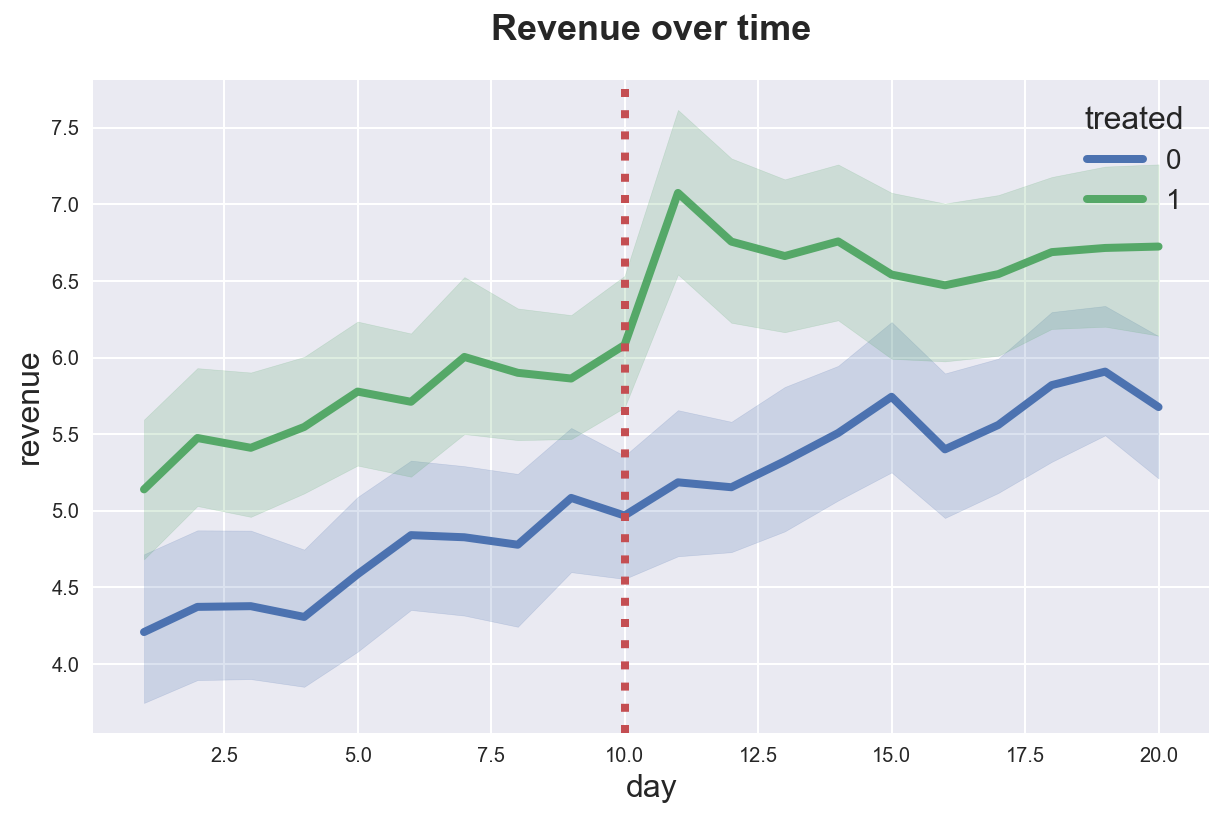

In [7]:
sns.lineplot(x=df['day'], y=df['revenue'], hue=df['treated']);
plt.axvline(x=10, ls=":", color='C2');
plt.title('Revenue over time');

It seems like the treatment group was producing higher revenues before treatment and the gap has increased with treatment but it is closing over time.

To assess the magnitude of the effect and perform inference, we can regress revenue on a post-treatment dummy, a treatment dummy and their interaction.

In [8]:
smf.ols('revenue ~ post * treated', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.6357,0.078,59.428,0.000,4.483,4.789
post[T.True],0.8928,0.110,8.093,0.000,0.676,1.109
treated,1.0558,0.110,9.571,0.000,0.839,1.272
post[T.True]:treated,0.1095,0.156,0.702,0.483,-0.196,0.415


While the coefficient for the interaction term is positive, it does not seem to be statistically significant. However, this might be due to the fact that the treatment effect is fading away over time. 

Let's fit the same regression, with a linear time trend.

In [9]:
smf.ols('revenue ~ post * treated * day', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.1144,0.168,24.501,0.000,3.785,4.444
post[T.True],0.2871,0.458,0.626,0.531,-0.612,1.186
treated,1.0788,0.237,4.543,0.000,0.613,1.544
post[T.True]:treated,1.5910,0.648,2.454,0.014,0.320,2.862
day,0.0948,0.027,3.502,0.000,0.042,0.148
post[T.True]:day,-0.0221,0.038,-0.576,0.564,-0.097,0.053
treated:day,-0.0042,0.038,-0.109,0.913,-0.079,0.071
post[T.True]:treated:day,-0.0929,0.054,-1.716,0.086,-0.199,0.013


Now the treatment effect is positive and significant at the 5% level. And indeed, we estimate a decreasing trend, post treatment, for the treated. However, it is not statistically significant.

## References

- [Video lecture on Difference-in-Differences](https://www.youtube.com/watch?v=mbYTZ0w-QTw) by Paul Goldsmith-Pinkham (Yale)
- [Chapter 13](https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html) of Causal Inference for The Brave and The True by Matheus Facure
- [Chapter 9](https://mixtape.scunning.com/difference-in-differences.html) of The Causal Inference Mixtape by Scott Cunningham
- Chapter 5 of [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/) by Agrist and Pischke